In [10]:
from torch import nn
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import numpy as np
from numpy import loadtxt
from PIL import Image
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

import os
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torch.optim as optim
import time
import copy

In [11]:
DATASET = '_Balance'

In [12]:
def get_ds(root, max_size=1024):
    # Applying Transforms to the Data
    image_transform = transforms.Compose([
            transforms.Resize(size=(224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
    ])
    
    directories = {
        type_: os.path.join(root, type_) for type_ in next(os.walk(root))[1]
    }
    types = directories.keys()

    # Batch size
    bs = 128

    # Number of classes
    num_classes = 2

    # Load Data from folders
    ds = {
        type_: datasets.ImageFolder(root=directories[type_], transform=image_transform)
                                    for type_ in  directories
    }
    
    dls = {type_: torch.utils.data.DataLoader(ds[type_], batch_size=bs, shuffle=True, num_workers=4)
              for type_ in types
    }
    dls = {type_: {"dl": dls[type_], "size": len(ds[type_]), "cls": ds[type_].classes} for type_ in types}
    return dls

['correct', 'incorrect']


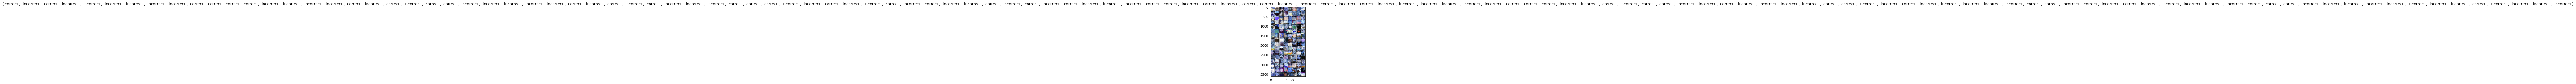

In [13]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

dataloaders = get_ds(DATASET)


class_names = dataloaders['train']['cls']
print(class_names)
inputs, classes = next(iter(dataloaders['train']['dl']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [14]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        t0 = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            full_len = len(dataloaders[phase]["dl"].dataset)
            completed = 0
            for inputs, labels in dataloaders[phase]["dl"]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                completed += len(labels)
                print(f"{completed}/{full_len}")
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            t1 = time.time()
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataloaders[phase]["size"]
            epoch_acc = running_corrects.double() / dataloaders[phase]["size"]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            print(f"time: {t1-t0}")
            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [15]:
model = torchvision.models.mobilenet_v3_small(pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu");model.classifier

Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=1000, bias=True)
)

In [16]:
# Model modification #
# ================== #
model.fc = nn.Linear(1024, 2)

In [17]:
# Learning parameters #
# =================== #

model = model.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [18]:
model_trained = train_model(model, criterion, optimizer, scheduler, num_epochs=25)

Epoch 0/24
----------
128/3000
256/3000
384/3000
512/3000
640/3000
768/3000
896/3000
1024/3000
1152/3000
1280/3000
1408/3000
1536/3000
1664/3000
1792/3000
1920/3000
2048/3000
2176/3000
2304/3000
2432/3000
2560/3000
2688/3000
2816/3000
2944/3000
3000/3000
train Loss: 4.9964 Acc: 0.2973
time: 77.13226294517517
128/750
256/750
384/750
512/750
640/750
750/750
test Loss: 1.9027 Acc: 0.5560
time: 83.62259769439697

Epoch 1/24
----------
128/3000
256/3000
384/3000
512/3000
640/3000
768/3000
896/3000
1024/3000
1152/3000
1280/3000
1408/3000
1536/3000
1664/3000
1792/3000
1920/3000
2048/3000
2176/3000
2304/3000
2432/3000
2560/3000
2688/3000
2816/3000
2944/3000
3000/3000
train Loss: 0.6099 Acc: 0.7843
time: 83.48022890090942
128/750
256/750
384/750
512/750
640/750
750/750
test Loss: 0.8410 Acc: 0.7480
time: 89.54272294044495

Epoch 2/24
----------
128/3000
256/3000
384/3000
512/3000
640/3000
768/3000
896/3000
1024/3000
1152/3000
1280/3000
1408/3000
1536/3000
1664/3000
1792/3000
1920/3000
2048/3000

In [19]:
torch.save(model_trained.state_dict(), 'models/mobilenet_v3_small_1_Linear_25e_Balance.pt')